In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Load dataset
df = pd.read_csv('C:/Users/sreej/OneDrive/Desktop/Datascience.csv')

In [4]:
from textblob import TextBlob

# Ensure the 'text' column is available
if 'text' in df.columns:
    df['sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
else:
    print("The 'text' column is missing. Sentiment cannot be calculated.")


In [5]:
df['created_at_utc'] = pd.to_datetime(df['created_at'], unit='s', errors='coerce')
df.set_index('created_at_utc', inplace=True)


C:\Users\sreej\AppData\Local\Temp\ipykernel_20616\3350772470.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sentiment = df['sentiment'].resample('M').mean()


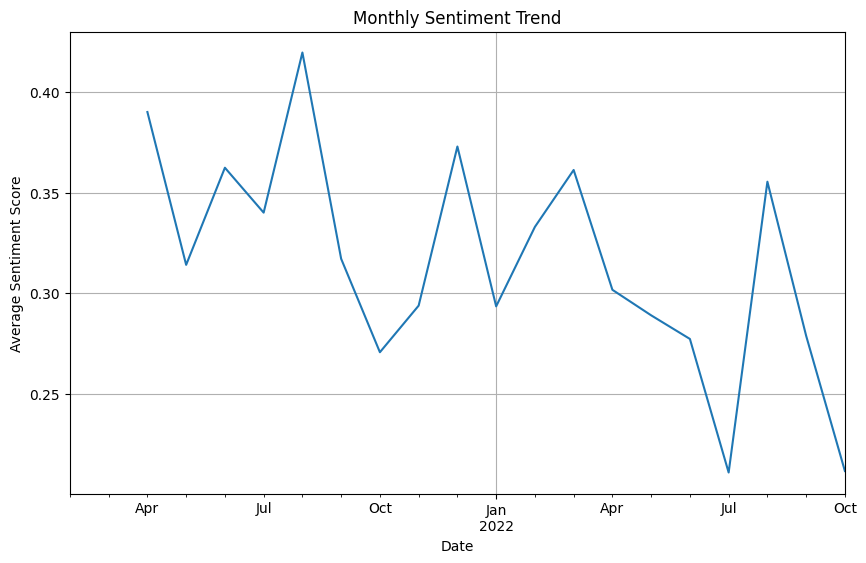

In [6]:
# Resample the data by month and calculate the mean sentiment score
monthly_sentiment = df['sentiment'].resample('M').mean()

# Plot the sentiment trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
monthly_sentiment.plot(kind='line')
plt.title('Monthly Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid()
plt.show()


In [7]:
print(df.head())  # To validate the new column
print(monthly_sentiment.head())  # To validate resampled data


                     Unnamed: 0  recipe_number  recipe_code  \
created_at_utc                                                
2022-10-13 00:11:29           0              1        14299   
2022-10-09 01:08:07           1              1        14299   
2022-09-28 22:35:57           2              1        14299   
2022-08-29 15:43:28           3              1        14299   
2022-10-04 20:03:43           4              1        14299   

                            recipe_name  \
created_at_utc                            
2022-10-13 00:11:29  Creamy White Chili   
2022-10-09 01:08:07  Creamy White Chili   
2022-09-28 22:35:57  Creamy White Chili   
2022-08-29 15:43:28  Creamy White Chili   
2022-10-04 20:03:43  Creamy White Chili   

                                                          comment_id  \
created_at_utc                                                         
2022-10-13 00:11:29  sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM   
2022-10-09 01:08:07  sp_aUSaElGf_14299_c

Actionable Business Insights
Address Negative Sentiment:

Investigate the specific causes of sentiment decline during the observed troughs.
Monitor and respond to user feedback actively during these periods.
Enhance Customer Experience:

Identify and replicate successful strategies used during periods of high sentiment.
Consider targeted marketing campaigns or product improvements during low-sentiment months.
Leverage Peaks for Promotions:

Capitalize on periods of high sentiment for promotions, product launches, or customer engagement initiatives.
Improve Feedback Mechanisms:

Use customer feedback to identify recurring themes in positive and negative sentiment.
Provide visible resolutions to issues raised during low-sentiment periods to rebuild trust.


Granular for recipe

C:\Users\sreej\AppData\Local\Temp\ipykernel_20616\490461711.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


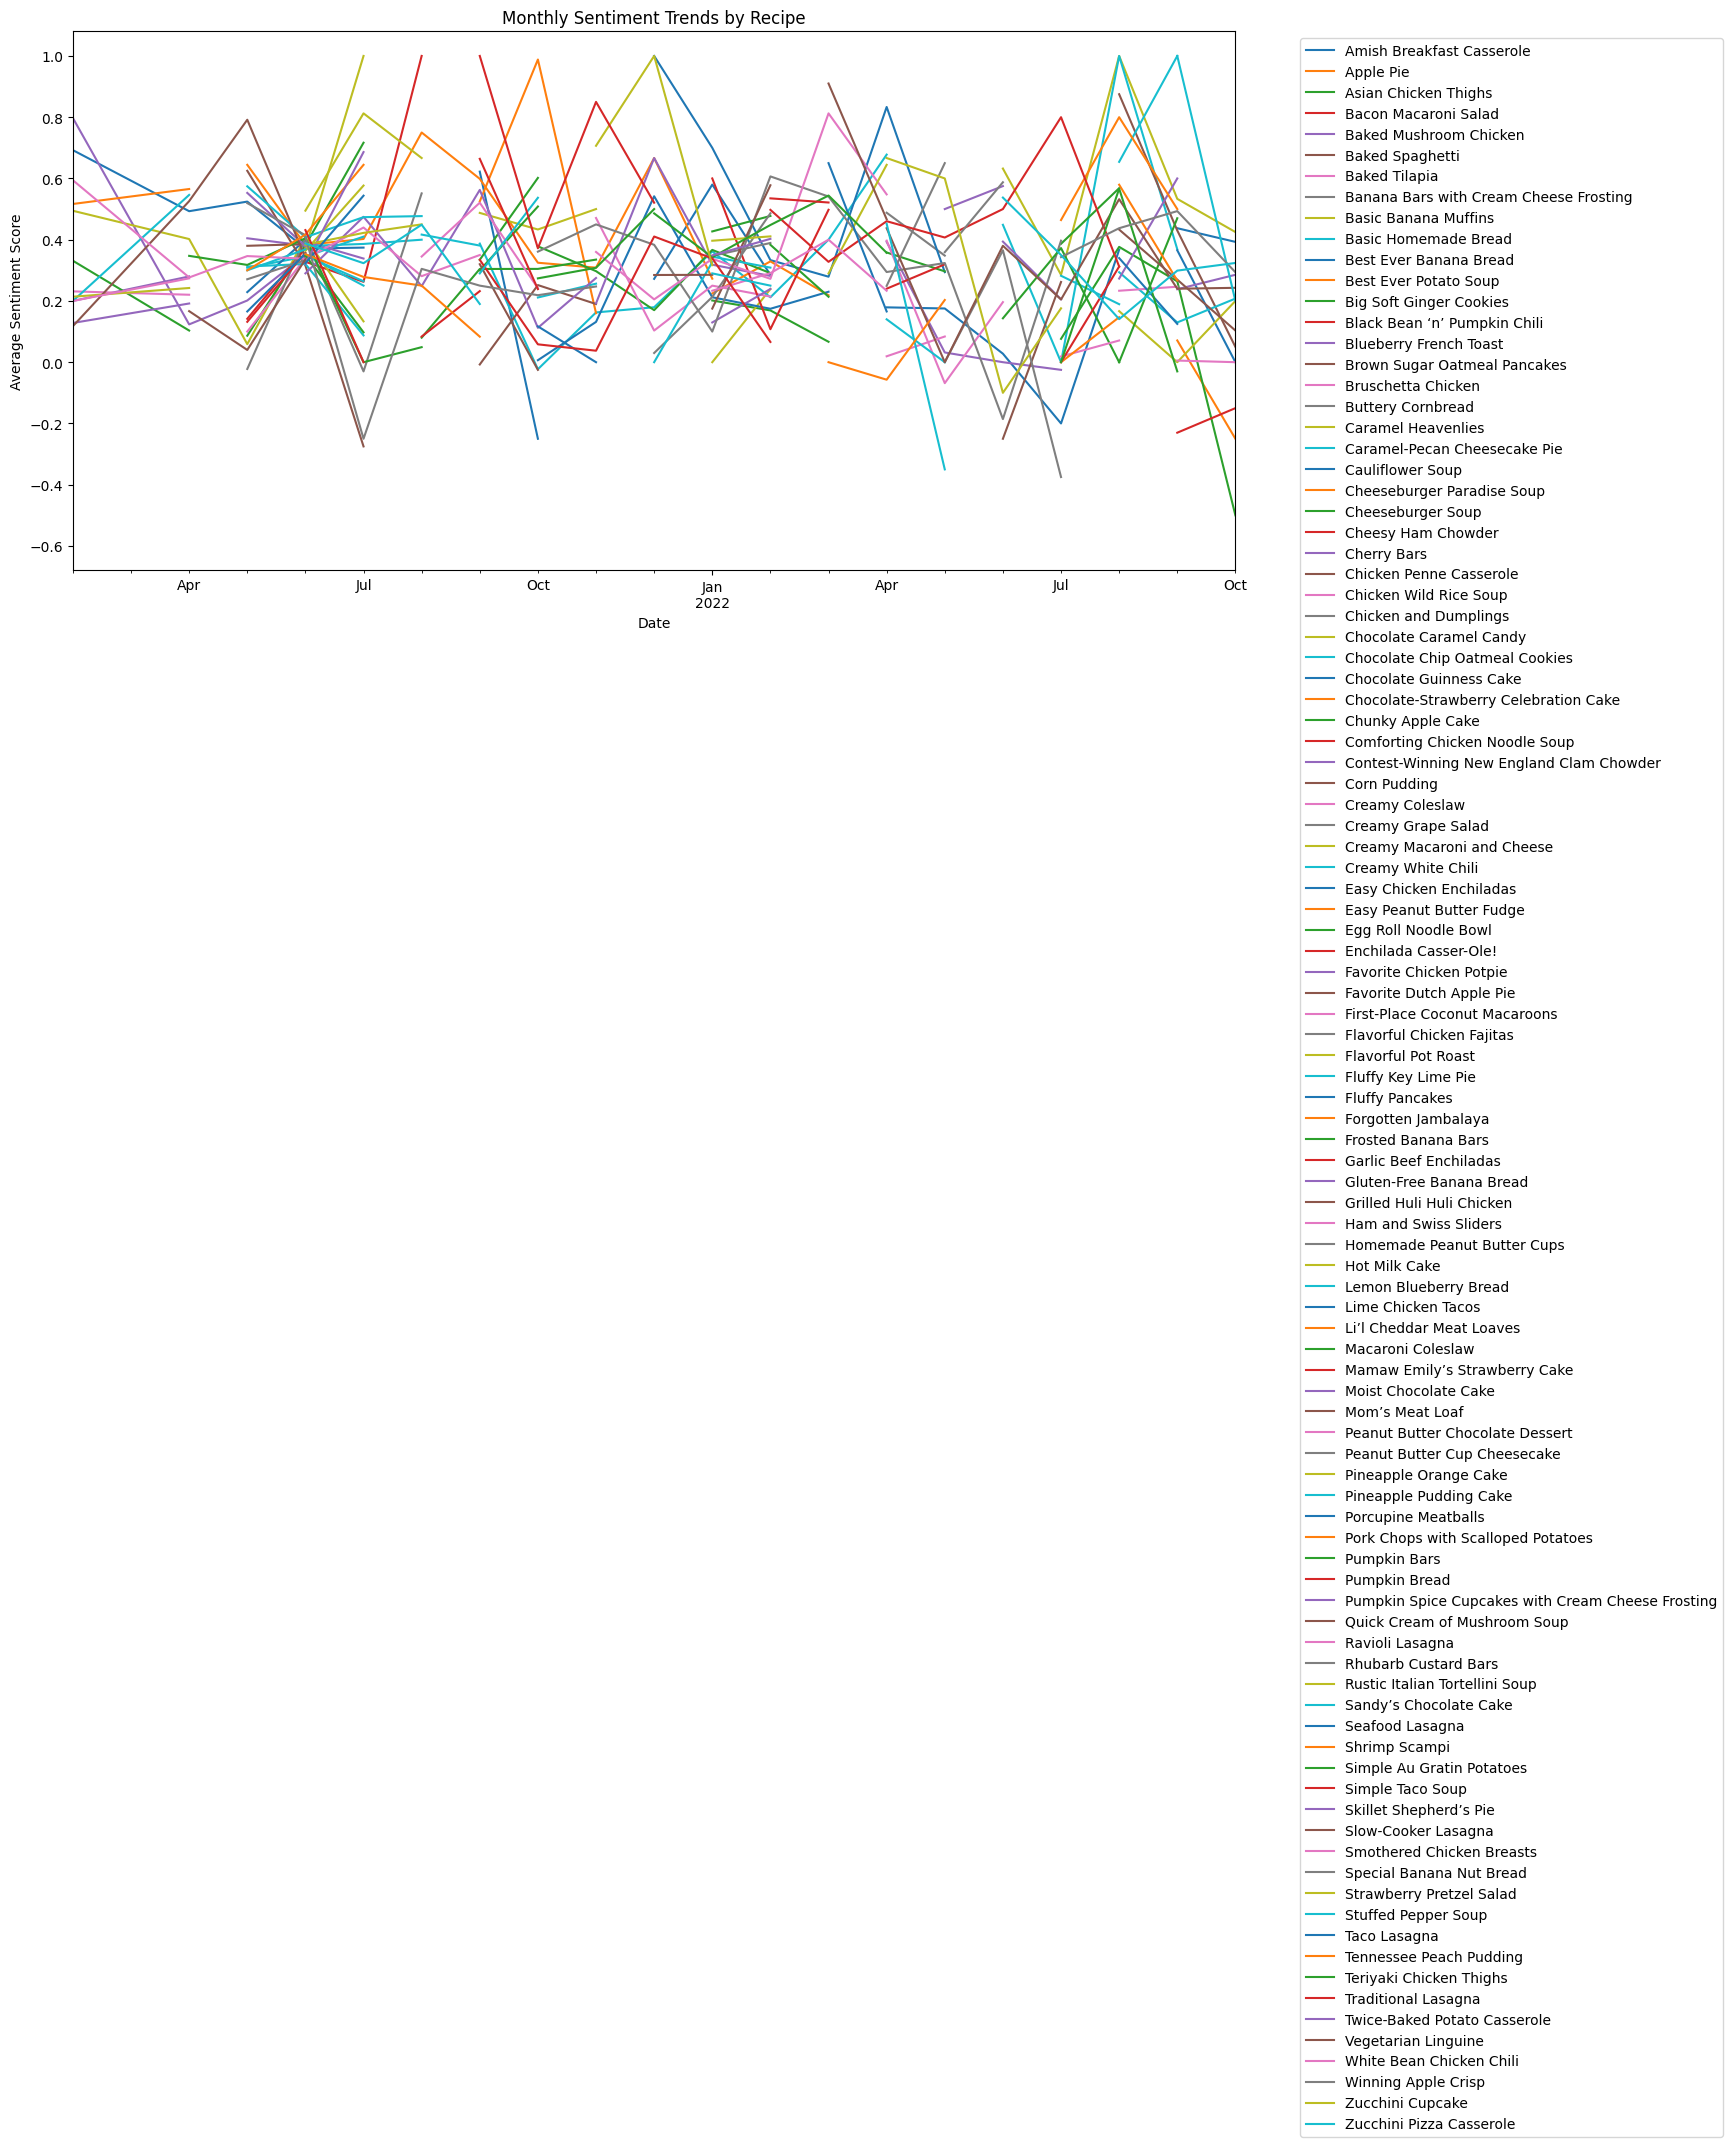

In [8]:
# Group sentiment trends by recipe name
recipe_sentiment = df.groupby(['recipe_name', df.index.to_period('M')])['sentiment'].mean().unstack()
recipe_sentiment.T.plot(figsize=(15, 7), title="Monthly Sentiment Trends by Recipe")
plt.ylabel('Average Sentiment Score')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


for user demographics

C:\Users\sreej\AppData\Local\Temp\ipykernel_20616\3285204681.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_sentiment = df.groupby(['user_reputation_level', df.index.to_period('M')])['sentiment'].mean().unstack()


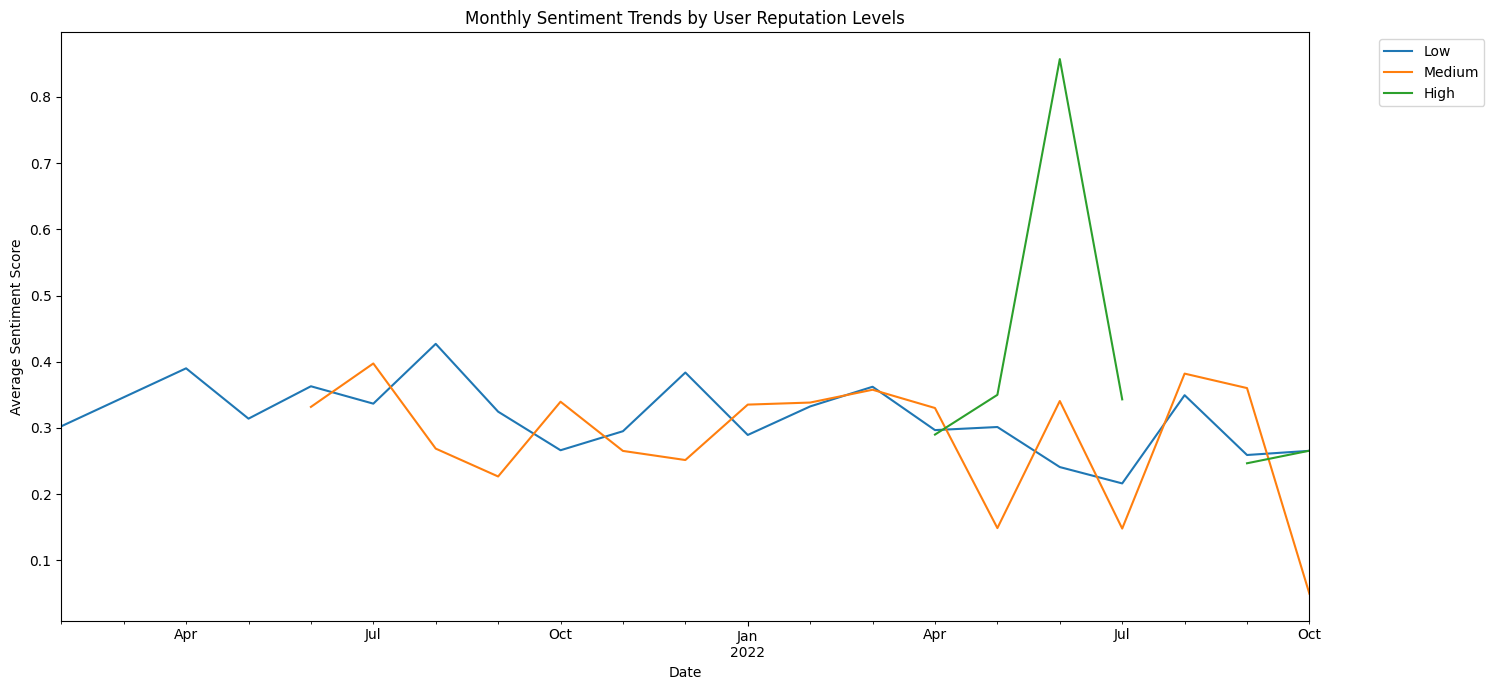

In [9]:
# Group sentiment trends by user reputation levels (e.g., low, medium, high reputation)
df['user_reputation_level'] = pd.cut(df['user_reputation'], bins=[-1, 10, 100, 1000], labels=['Low', 'Medium', 'High'])
user_sentiment = df.groupby(['user_reputation_level', df.index.to_period('M')])['sentiment'].mean().unstack()
user_sentiment.T.plot(figsize=(15, 7), title="Monthly Sentiment Trends by User Reputation Levels")
plt.ylabel('Average Sentiment Score')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


predictive-Arima

C:\Users\sreej\AppData\Local\Temp\ipykernel_20616\4233316762.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sentiment = df['sentiment'].resample('M').mean()


                               SARIMAX Results                                
Dep. Variable:              sentiment   No. Observations:                   21
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  27.301
Date:                Wed, 11 Dec 2024   AIC                            -48.601
Time:                        11:49:42   BIC                            -45.614
Sample:                    02-28-2021   HQIC                           -48.018
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1878      0.390      0.481      0.630      -0.577       0.953
ma.L1         -0.9979      7.659     -0.130      0.896     -16.009      14.013
sigma2         0.0029      0.021      0.137      0.8

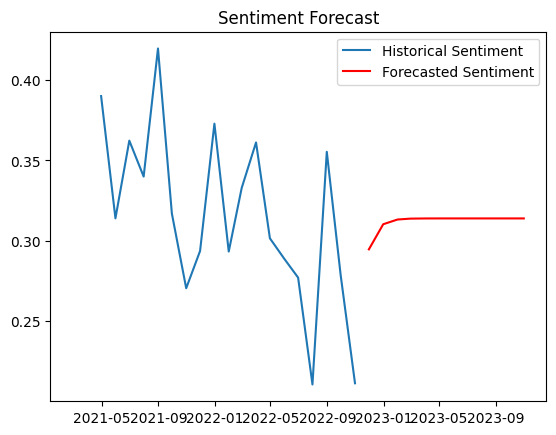

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for ARIMA
monthly_sentiment = df['sentiment'].resample('M').mean()

# Fit ARIMA model
arima_model = ARIMA(monthly_sentiment, order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Forecast sentiment
forecast = arima_result.forecast(steps=12)
plt.plot(monthly_sentiment, label='Historical Sentiment')
plt.plot(forecast, label='Forecasted Sentiment', color='red')
plt.title('Sentiment Forecast')
plt.legend()
plt.show()


sentiment categorization

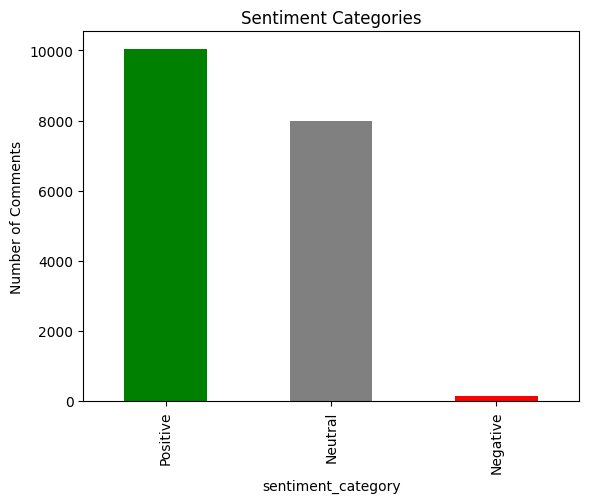

In [11]:
# Categorize sentiment scores
def categorize_sentiment(score):
    if score > 0.3:
        return 'Positive'
    elif score < -0.3:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)

# Visualize sentiment categories
category_counts = df['sentiment_category'].value_counts()
category_counts.plot(kind='bar', color=['green', 'gray', 'red'], title='Sentiment Categories')
plt.ylabel('Number of Comments')
plt.show()


Feedback Tagging

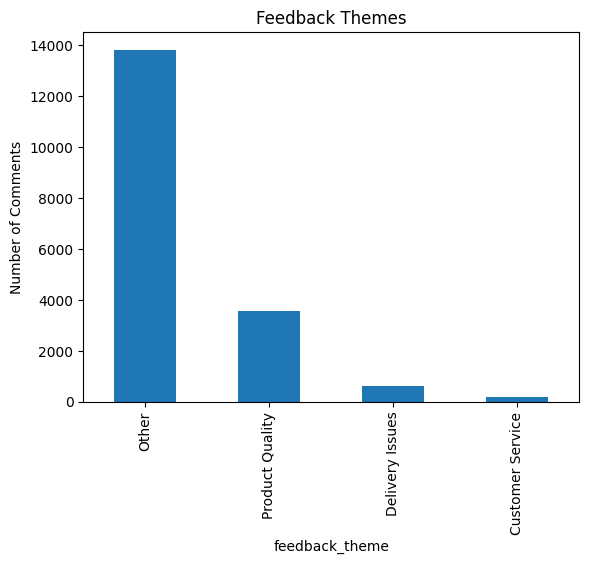

In [13]:
# Ensure 'text' column is filled and converted to strings
df['text'] = df['text'].fillna('').astype(str)

# Define themes and keywords
themes = {
    'Product Quality': ['taste', 'quality', 'flavor'],
    'Delivery Issues': ['late', 'delay', 'delivery'],
    'Customer Service': ['support', 'help', 'service']
}

def tag_feedback(text):
    for theme, keywords in themes.items():
        if any(keyword in text.lower() for keyword in keywords):
            return theme
    return 'Other'

# Apply the tagging function
df['feedback_theme'] = df['text'].apply(tag_feedback)

# Visualize feedback themes
theme_counts = df['feedback_theme'].value_counts()
theme_counts.plot(kind='bar', title='Feedback Themes')
plt.ylabel('Number of Comments')
plt.show()


From the visualizations and analysis, we can draw the following insights:

Monthly Sentiment Trends by Recipe:

The sentiment trends vary significantly across different recipes.
Some recipes consistently have higher sentiment scores, indicating positive feedback, while others fluctuate.
Monthly Sentiment Trends by User Reputation:

Users with high reputations show sharper fluctuations in sentiment scores, possibly indicating more impactful or influential reviews.
Medium and low-reputation users show relatively consistent trends, highlighting their uniform feedback patterns.
Sentiment Forecast:

The SARIMAX model forecasts a steady sentiment trend, indicating stabilization in user opinions over time.
This information can help predict potential dips or surges in sentiment, aiding in preemptive actions.
Sentiment Categories:

Most feedback is categorized as positive, with a smaller proportion as neutral and very few negative comments.
This shows overall satisfaction but highlights the need to address neutral and negative feedback for improvement.
Feedback Themes:

The majority of feedback falls under "Other," suggesting undefined themes.
Product quality issues dominate the categorized feedback, followed by delivery and customer service issues.
Recommendations for Business:
Granular Recipe Insights: Focus on recipes with consistently low sentiment to understand specific improvement areas.
Targeted Engagement: Engage high-reputation users to leverage their influence and address their concerns proactively.
Proactive Strategy Development: Use the sentiment forecast to align marketing and operational strategies with expected trends.
Theme-based Improvement: Concentrate efforts on improving product quality, delivery, and customer service as they are key drivers of negative or neutral feedback.












Another try for individual Recipe